In [1]:
import jax
from functools import partial
from jax import grad, jacfwd, vmap, jit, hessian
from jax.lax import scan, stop_gradient
# from jax.ops import index_update, index
import jax.random as jnp_random
import jax.numpy as np
from jax.nn.initializers import glorot_normal, normal, uniform

from jax.example_libraries import stax, optimizers
from jax.example_libraries.stax import elementwise, Tanh, Selu, Relu
from jax.flatten_util import ravel_pytree

import numpy as onp

from utils import rk4_step

def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.power( np.linspace(start, stop, num=num), power) 

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
A = np.array([[0.,1.],[0.,0.]])
B = np.array([[0.],[1.]]).squeeze()

n,m,T = 4, 1, 50

# def ell(x, u):
#     return np.sum(np.square(x) + 0.01 * np.square(u))

def ell(x, u):
    th, p, thdot, xdot = x
    return -np.cos(th) + 0.01*p**6 + 0.01*np.sum(u**2)
# def f(x, u):
#     return A@x + np.array([0., np.tanh(u[0])])

_sat = 4.0
def f(s, a):
    th, x, thdot, xdot = s
    u_acc = _sat*np.tanh(a[0])
    return np.array([
                thdot, xdot,
                9.81*np.sin(th)/1.0+u_acc*np.cos(th)/1.0-0.2*thdot,
                u_acc-0.2*xdot])

def adjoint(x, u, rho):
    return grad(ell)(x, u) + jacfwd(f)(x, u).T @ rho

# def u_prime(x, rho):
#     return -1/0.002 * jacfwd(f,argnums=1)(x,np.ones(m)).T @ rho

def Hamiltonian(x, u, rho):
    return rho @ f(x, u) + ell(x, u)


2023-11-02 17:13:37.028334: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
def sin(x):
    return np.sin(x)
Sin = elementwise(sin)
x_init, x_net = stax.serial(
    # stax.Dense(256, W_init=normal(stddev=10.0)),Sin,
    stax.Dense(164),Tanh,
    stax.Dense(164),Tanh,
    stax.Dense(n)
)

rho_init, rho_net = stax.serial(
    stax.Dense(164),Tanh,
    stax.Dense(164),Tanh,
    stax.Dense(n)
)
u_init, u_net = stax.serial(
    stax.Dense(164),Tanh,
    stax.Dense(164),Tanh,
    stax.Dense(m)
)

rho_dot = jacfwd(rho_net, argnums=1)
x_dot = jacfwd(x_net, argnums=1)
# x0 = np.ones((n,))
x0 = np.array([3.1, 0.1, 0., 0.])

rng = jnp_random.PRNGKey(0)
in_shape = (-1, n)
_, x_params = x_init(rng, (-1,1))
rng, _rng_val = jnp_random.split(rng, 2)
_, rho_params = rho_init(_rng_val, (-1,1))
rng, _rng_val = jnp_random.split(rng, 2)
_, u_params = u_init(rng, (-1, 1))

In [4]:
opt_init, opt_update, get_params = optimizers.adam(step_size=3e-4)
opt_state = opt_init([x_params, rho_params, u_params])

In [5]:
def loss(params, t):
    x_params, rho_params, u_params = params
    dxdt    = vmap(x_dot, in_axes=(None, 0))(x_params, t).squeeze()
    drhodt  = vmap(rho_dot, in_axes=(None, 0))(rho_params, t).squeeze()
    x       = vmap(x_net, in_axes=(None, 0))(x_params, t).squeeze()
    rho     = vmap(rho_net, in_axes=(None, 0))(rho_params, t).squeeze()
    u       = vmap(u_net, in_axes=(None, 0))(u_params, t)[:,:,0]#.squeeze()
    return np.mean((dxdt - vmap(f)(x, u))**2 \
            + (drhodt + vmap(adjoint)(x, u, rho))**2 \
            + (x[0]-x0)**2 + (rho[-1] - grad(ell)(x[-1], u[-1]))**2) \
            + np.mean(vmap(Hamiltonian)(stop_gradient(x), u, stop_gradient(rho)))

@jit 
def step(i, opt_state, t):
    params = get_params(opt_state)
    g = grad(loss)(params, t)
    return opt_update(i, g, opt_state)


-0.5687279


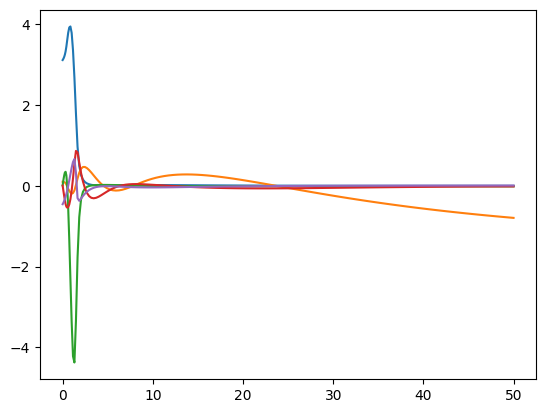

In [6]:
# t = np.linspace(0, T, num=200)
t = powspace(0, T, power=2, num=100)
for i in range(10000):
    _t = np.array(
        onp.concatenate([
            [0.0],onp.random.uniform(0,T, size=(100,)), [T] ]
            ))
    opt_state = step(i, opt_state, _t)
    if i % 100 == 0:
        clear_output(wait=True)
        x_params, rho_params, u_params = get_params(opt_state)
        print(loss(get_params(opt_state), t))
        _x = vmap(x_net, in_axes=(None,0))(x_params, t).squeeze()
        _rho = vmap(rho_net, in_axes=(None,0))(rho_params, t).squeeze()
        _u = vmap(u_net, in_axes=(None,0))(u_params, t).squeeze()
        plt.plot(t, _x)
        plt.plot(t, _u)
        plt.pause(0.01)

In [7]:
print(loss(get_params(opt_state), t))
x_params, rho_params, u_params = get_params(opt_state)

-0.5708559


In [8]:
x = vmap(x_net, in_axes=(None,0))(x_params, t).squeeze()
rho = vmap(rho_net, in_axes=(None,0))(rho_params, t).squeeze()
u = vmap(u_net, in_axes=(None,0))(u_params, t)


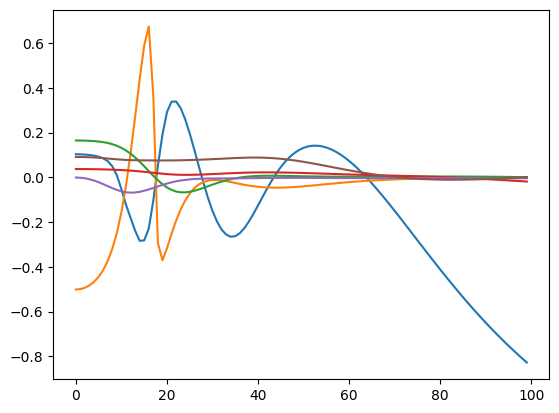

In [9]:
plt.plot(x[:, 1])
plt.plot(u.squeeze())
plt.plot(rho)
# plt.plot(vmap(f)(x,u)-vmap(x_dot, in_axes=(None, 0))(x_params, t).squeeze())
# plt.plot(vmap(x_dot, in_axes=(None, 0))(x_params, t).squeeze())
# plt.plot(u)

#### Evaluate the trained policy

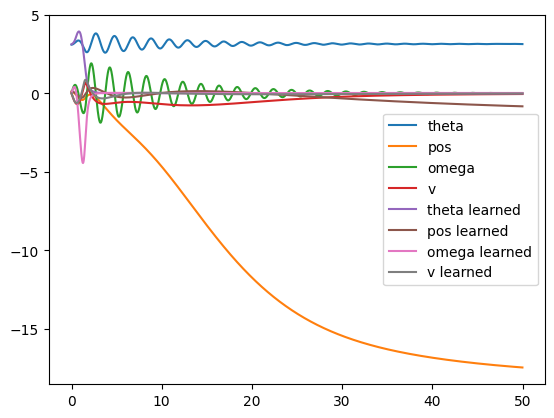

In [10]:
tf = T
dt = 0.01
ts = np.arange(0, tf, dt)
get_control = jax.jit(u_net)
xs = [x0]
us = []

xs_learned = onp.array(vmap(x_net, in_axes=(None,0))(x_params, ts).squeeze())

for t in ts:
    u = get_control(u_params, t)[0]
    us.append(u)
    x = rk4_step(f, xs[-1], u, dt)
    xs.append(x)

xs = onp.array(xs)

plt.figure()
plt.plot(ts, xs[:-1, 0], label="theta")
plt.plot(ts, xs[:-1, 1], label="pos")
plt.plot(ts, xs[:-1, 2], label="omega")
plt.plot(ts, xs[:-1, 3], label="v")

plt.plot(ts, xs_learned[:, 0], label="theta learned")
plt.plot(ts, xs_learned[:, 1], label="pos learned")
plt.plot(ts, xs_learned[:, 2], label="omega learned")
plt.plot(ts, xs_learned[:, 3], label="v learned")

plt.legend()
plt.show()

In [11]:
import meshcat
import meshcat.geometry as geom
import meshcat.transformations as tfm
import time

class CartpoleVis(meshcat.Visualizer):
    def __init__(self,):
        super().__init__()
        
        self.world_frame = self["world_frame"]
        self.world_frame.set_transform((
            onp.array([
            [0, 0, 1, 0],
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 0, 1]], dtype=onp.float64)
        ))

        self.cart = self.world_frame["cart"]
        self.cart.set_object(geom.Box([2, 1, 0.1]))

        self.pole_pivot = self.cart["pivot"]
        self.pole_pivot.set_object(geom.Sphere(0.2), geom.MeshPhongMaterial(color=0x000000))

        self.pole_bar_cm = self.pole_pivot["pole_bar_cm"]
        self.pole_bar_cm.set_object(geom.Box([4, 0.2, 0.1]), geom.MeshPhongMaterial(color=0x008000))
        self.pole_bar_cm.set_transform(tfm.translation_matrix([4/2, 0, 0]))

        self.pole = self.pole_pivot["pole"]
        self.pole.set_object(geom.Sphere(0.3), geom.MeshPhongMaterial(color=0x0000FF))
        self.pole.set_transform(tfm.translation_matrix([4, 0, 0]))

    def render(self, q):
        self.cart.set_transform(tfm.translation_matrix([q[1], 0, 0]))
        self.pole_pivot.set_transform(tfm.rotation_matrix(q[0]+np.pi/2, [0,0,1]))

vis = CartpoleVis()
vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [17]:
for x in xs:
    vis.render(x)
    time.sleep(dt)

KeyboardInterrupt: 

In [ ]:
vis_learned_trajectory = CartpoleVis()
vis_learned_trajectory.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/


In [18]:
for x_learned in xs_learned:
    vis_learned_trajectory.render(x_learned)
    time.sleep(dt)

### Drone dynamics

In [ ]:
from drone import DroneDynamics
from transform_lib import euler2mat

In [ ]:
drone = DroneDynamics()
_R = euler2mat([0.2,0.4,0.5])
_p = np.ones(3)*1.
_w = np.ones(3)*0.
_v = np.ones(3)*0.
x0 = np.concatenate([_R.ravel(), _p, _w, _v])

Rd = onp.eye(3)
Q = onp.diag([1.0,1.0,100.])
def ell(x, u):
    R = x[:9].reshape((3,3))
    p = x[9:12]
    w = x[12:15]
    v = x[15:]
    # tr_RtR = np.trace(R.T@Rd)
    # _arc_c_arg = (tr_RtR - 1.)/2.0
    # _th = np.arccos(_arc_c_arg)
    R_err = np.linalg.norm(np.eye(3)-R)
    _p_err = np.sum(Q@np.square(p - np.array([0.,0.,0.])))
    return _p_err + R_err\
                + 1e-4*np.sum(np.square(v)) \
                + 1e-4*np.sum(np.square(w)) 

In [ ]:
n, m, T = 18, 4, 10

f = lambda x, u: drone.f(x,u)

def adjoint(x, u, rho):
    return grad(ell)(x, u) + jacfwd(f)(x, u).T @ rho

def Hamiltonian(x, u, rho):
    return rho @ f(x, u) + ell(x, u)

In [ ]:
def sin(x):
    return np.sin(x)
Sin = elementwise(sin)
x_init, x_net = stax.serial(
    stax.Dense(64),Tanh,
    stax.Dense(64),Tanh,
    stax.Dense(n)
)

rho_init, rho_net = stax.serial(
    stax.Dense(64),Tanh,
    stax.Dense(64),Tanh,
    stax.Dense(n)
)
u_init, u_net = stax.serial(
    stax.Dense(64),Tanh,
    stax.Dense(64),Tanh,
    stax.Dense(m)
)

rho_dot = jacfwd(rho_net, argnums=1)
x_dot = jacfwd(x_net, argnums=1)
# x0 = np.ones((n,))
# x0 = np.array([3.1, 0.1, 0., 0.])

rng = jnp_random.PRNGKey(0)
# in_shape = (-1, n)
_, x_params = x_init(rng, (-1,1))
rng, _rng_val = jnp_random.split(rng, 2)
_, rho_params = rho_init(_rng_val, (-1,1))
rng, _rng_val = jnp_random.split(rng, 2)
_, u_params = u_init(rng, (-1, 1))

In [ ]:
def loss(params, t):
    x_params, rho_params, u_params = params
    dxdt    = vmap(x_dot, in_axes=(None, 0))(x_params, t).squeeze()
    drhodt  = vmap(rho_dot, in_axes=(None, 0))(rho_params, t).squeeze()
    x       = vmap(x_net, in_axes=(None, 0))(x_params, t).squeeze()
    rho     = vmap(rho_net, in_axes=(None, 0))(rho_params, t).squeeze()
    u       = vmap(u_net, in_axes=(None, 0))(u_params, t).squeeze()
    return np.mean((dxdt - vmap(f)(x, u))**2 \
            + (drhodt + vmap(adjoint)(x, u, rho))**2 \
            + (x[0]-x0)**2 + rho[-1]**2) \
            + np.mean(vmap(Hamiltonian)(stop_gradient(x), u, stop_gradient(rho)))

@jit 
def step(i, opt_state, t):
    params = get_params(opt_state)
    g = grad(loss)(params, t)
    return opt_update(i, g, opt_state)


In [ ]:
opt_init, opt_update, get_params = optimizers.adam(step_size=3e-3)
opt_state = opt_init([x_params, rho_params, u_params])

In [ ]:
# t = np.linspace(0, T, num=200)
t = powspace(0, T, power=2, num=200)
for i in range(10000):
    opt_state = step(i, opt_state, t)
    if i % 100 == 0:
        clear_output(wait=True)
        x_params, rho_params, u_params = get_params(opt_state)
        print(loss(get_params(opt_state), t))
        _x = vmap(x_net, in_axes=(None,0))(x_params, t).squeeze()
        _rho = vmap(rho_net, in_axes=(None,0))(rho_params, t).squeeze()
        _u = vmap(u_net, in_axes=(None,0))(u_params, t).squeeze()
        plt.plot(t, _x[:,9:12])
        # plt.plot(t, _u)
        plt.pause(0.01)

In [ ]:
plt.plot(_rho)